# Аналитика в Яндекс.Афише

В нашем распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо проанализировать данные и оптимизировать маркетинговые затраты. Для этого необходимо ответить на следующие вопросы:
1. Как люди пользуются продуктом? 
2. Когда они начинают покупать?
3. Сколько денег приносит каждый клиент?
4. Когда клиент окупается?

### Шаг 1. Предобработка данных

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')

In [212]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [213]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Таблица visits (лог сервера с информацией о посещениях сайта):

1. Uid — уникальный идентификатор пользователя
2. Device — категория устройства пользователя
3. Start Ts — дата и время начала сессии
4. End Ts — дата и время окончания сессии
5. Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [214]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Переименуем столбцы в более удобный для анализа вид.

In [215]:
visits.columns = map(str.lower, visits.columns)

In [216]:
visits.columns

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

In [217]:
visits = visits.rename(
    columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'})

In [218]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [219]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [220]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Таблица orders (информация о заказах):

1. Uid — уникальный id пользователя, который сделал заказ
2. Buy Ts — дата и время заказа
3. Revenue — выручка Яндекс.Афиши с этого заказа

In [221]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В этой таблице также первым делом приведем в порядок названия столбцов.

In [222]:
orders.columns = map(str.lower, orders.columns)
orders = orders.rename(
    columns={'buy ts':'buy_ts'})

In [223]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [224]:
costs = pd.read_csv('/datasets/costs.csv')

In [225]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица costs (информация о затратах на маркетинг):

1. source_id — идентификатор рекламного источника
2. dt — дата
3. costs — затраты на этот рекламный источник в этот день

In [226]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблицах содержится различная информация о датах. Приведем соответствующие данные к правильному типу.

In [227]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M")
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d %H:%M")

In [228]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [229]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [230]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


В нашем распоряжении три таблицы, описывающие поведение пользователей Яндекс.Афиши в течение года.
Для оптимизации маркетинговых затрат необходимо определить удачные каналы привлечения, а также оценить различия в поведении пользователей на десктопной версии сайта и в приложении.

# Шаг 2. Анализ поведения пользователей

## Анализ посещения сайта

Познакомимся подробнее с таблицей visits. Для анализа мы будем исследовать общий датафрейм и дополнительно два среза в зависимости от устройства: desktop и touch. Ответим на следующие вопросы:

1. Сколько людей пользуются в день, неделю, месяц?
2. Сколько сессий в день?
3. Сколько длится одна сессия?
4. Как часто люди возвращаются?


Выделим из даты начала сессий год, месяц, неделю и день. 
Определим для каждого пользователя месяц первого посещения.

In [231]:
visits['visit_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['visit_week'] = visits['start_ts'].astype('datetime64[W]')
visits['visit_day'] = visits['start_ts'].astype('datetime64[D]')

In [232]:
first_visit_month = visits.groupby(['uid'])['visit_month'].min()
first_visit_month.name = 'first_visit_month'
visits = visits.join(first_visit_month,on='uid')

В столбце duration сохраним продорлжительность одной сессии в минутах.

In [233]:
visits['duration'] = (visits['end_ts'] - visits['start_ts'])/np.timedelta64(1, 'm')

Создадим два новых датафрейма по устройствам. Определим, сколько пользователей пользуются Яндекс.Афишей в среднем, а также среднее число сессий.

In [234]:
visits_desktop = visits[visits['device'] == 'desktop']
visits_touch = visits[visits['device'] == 'touch']

In [235]:
def users_sessions(data):
    data_day = data.groupby('visit_day').agg({'uid':'nunique', 'start_ts':'count'}).reset_index()
    users_day = data_day['uid'].mean().round()
    sessions_day = data_day['start_ts'].mean().round()
    data_week = data.groupby('visit_week').agg({'uid':'nunique', 'start_ts':'count'}).reset_index()
    users_week = data_week['uid'].mean().round()
    sessions_week = data_week['start_ts'].mean().round()
    data_month = data.groupby('visit_month').agg({'uid':'nunique', 'start_ts':'count'}).reset_index()
    users_month = data_month['uid'].mean().round()
    sessions_month = data_month['start_ts'].mean().round()
    print ('Среднее число пользователей в день:', users_day)
    print ('Среднее число сессий в день:', sessions_day)
    print ('Среднее число пользователей в неделю:', users_week)
    print ('Среднее число сессий в неделю:', sessions_week)
    print ('Среднее число пользователей в месяц:', users_month)
    print ('Среднее число сессий в месяц:', sessions_month)

In [236]:
users_sessions(visits)

Среднее число пользователей в день: 908.0
Среднее число сессий в день: 987.0
Среднее число пользователей в неделю: 5724.0
Среднее число сессий в неделю: 6781.0
Среднее число пользователей в месяц: 23228.0
Среднее число сессий в месяц: 29950.0


In [237]:
users_sessions(visits_desktop)

Среднее число пользователей в день: 659.0
Среднее число сессий в день: 721.0
Среднее число пользователей в неделю: 4136.0
Среднее число сессий в неделю: 4954.0
Среднее число пользователей в месяц: 16725.0
Среднее число сессий в месяц: 21881.0


In [238]:
users_sessions(visits_touch)

Среднее число пользователей в день: 253.0
Среднее число сессий в день: 267.0
Среднее число пользователей в неделю: 1637.0
Среднее число сессий в неделю: 1827.0
Среднее число пользователей в месяц: 6826.0
Среднее число сессий в месяц: 8069.0


Text(0.5, 1.0, 'Среднее число пользователей в месяц')

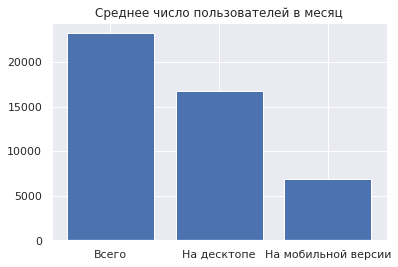

In [239]:
a_dictionary = {"Всего": 23228, "На десктопе": 16725, "На мобильной версии": 6826}
keys = a_dictionary.keys()
values = a_dictionary.values()

plt.bar(keys, values)
plt.title('Среднее число пользователей в месяц')

Text(0.5, 1.0, 'Среднее число сессий в месяц')

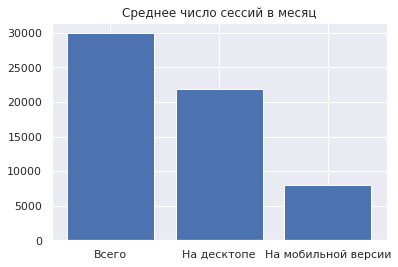

In [240]:
a_dictionary = {"Всего": 29950, "На десктопе": 21881, "На мобильной версии": 8069}
keys = a_dictionary.keys()
values = a_dictionary.values()

plt.bar(keys, values)
plt.title('Среднее число сессий в месяц')

По полученным метрикам очевидно, что десктопная версия Яндекс.Афиши популярнее мобильной. И сессий, и пользователей в среднем больше именно на десткопной версии. 

Посмотрим на эти метрики в разбивке по годам.

In [241]:
visits_2017 = visits[visits['visit_year'] == '2017']
visits_2018 = visits[visits['visit_year'] == '2018']

In [242]:
users_sessions(visits_2017)

Среднее число пользователей в день: 845.0
Среднее число сессий в день: 918.0
Среднее число пользователей в неделю: 5350.0
Среднее число сессий в неделю: 6337.0
Среднее число пользователей в месяц: 21728.0
Среднее число сессий в месяц: 28064.0


In [243]:
users_sessions(visits_2018)

Среднее число пользователей в день: 997.0
Среднее число сессий в день: 1086.0
Среднее число пользователей в неделю: 5988.0
Среднее число сессий в неделю: 7085.0
Среднее число пользователей в месяц: 25329.0
Среднее число сессий в месяц: 32590.0


Наблюдается рост и среднего числа пользователей, и среднего числа сессий. Хороший знак для Яндекс.Афиши. 

In [244]:
visits_desktop_2017 = visits_2017[visits_2017['device'] == 'desktop']
visits_touch_2017 = visits_2017[visits_2017['device'] == 'touch']
visits_desktop_2018 = visits_2018[visits_2018['device'] == 'desktop']
visits_touch_2018 = visits_2018[visits_2018['device'] == 'touch']

In [245]:
users_sessions(visits_desktop_2017)

Среднее число пользователей в день: 621.0
Среднее число сессий в день: 677.0
Среднее число пользователей в неделю: 3919.0
Среднее число сессий в неделю: 4675.0
Среднее число пользователей в месяц: 15864.0
Среднее число сессий в месяц: 20706.0


In [246]:
users_sessions(visits_desktop_2018)

Среднее число пользователей в день: 714.0
Среднее число сессий в день: 784.0
Среднее число пользователей в неделю: 4254.0
Среднее число сессий в неделю: 5114.0
Среднее число пользователей в месяц: 17931.0
Среднее число сессий в месяц: 23526.0


На десктопе число пользователей в день в 2018 году увеличилось на 14,97%, число сессий в день увеличилось на 15,81%.

In [247]:
users_sessions(visits_touch_2017)

Среднее число пользователей в день: 228.0
Среднее число сессий в день: 241.0
Среднее число пользователей в неделю: 1480.0
Среднее число сессий в неделю: 1662.0
Среднее число пользователей в месяц: 6178.0
Среднее число сессий в месяц: 7359.0


In [248]:
users_sessions(visits_touch_2018)

Среднее число пользователей в день: 289.0
Среднее число сессий в день: 304.0
Среднее число пользователей в неделю: 1780.0
Среднее число сессий в неделю: 1971.0
Среднее число пользователей в месяц: 7734.0
Среднее число сессий в месяц: 9064.0


На мобильной версии число пользователей в день в 2018 году увеличилось на 26,75%, число сессий в день увеличилось на 26,14%.

Определим, сколько в среднем длится одна сессия.

In [249]:
visits['duration'].mode()

0    1.0
dtype: float64

Пользователи Яндекс.Афиша чаще всего находятся на сайте 1 минуту. Это может означать две вещи: либо пользователям все предельно понятно на сайте и поэтому они быстро совершают покупки, либо пользователи заходят на сайт и сразу же покидают его.

In [250]:
visits['duration'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: duration, dtype: float64

При этом средняя длительность сессии - около 10 минут. А половина пользователей проводит на сайте менее 5 минут.

Отметим, что нашлась отрицательная продолжительность сессии, и посмотрим на эти строки подробнее.

In [251]:
visits.query('duration < 0')

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_day,first_visit_month,duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-01-01,2018-03-01,2018-03-22,2018-03-25,2017-11-01,-32.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-01-01,2018-03-01,2018-03-22,2018-03-25,2018-03-01,-46.0


В двух строках возможно произошла ошибка в значениях старта и окончания сессии. Из-за этого возникли отрицательные результаты длительности сессий. Необходимо сообщить коллегам, предоставившим выгрузку, о возникшей ошибке.

In [252]:
visits['duration'].value_counts()

1.0      53029
0.0      35794
2.0      35748
3.0      26672
4.0      21085
         ...  
317.0        1
419.0        1
270.0        1
316.0        1
524.0        1
Name: duration, Length: 312, dtype: int64

Text(0.5, 0, 'Продолжительность сессии в минутах всех визитов')

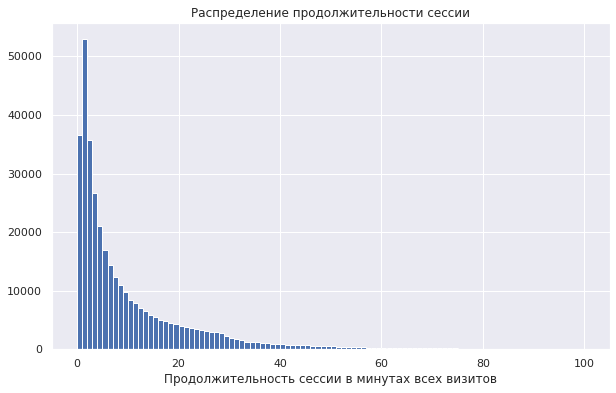

In [253]:
plt.figure(figsize = (10,6))
visits['duration'].hist(bins=100, range = (0,100))
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительность сессии в минутах всех визитов')

Посмотрим, отличается ли продолжительность сессий на устройствах.

In [254]:
visits_desktop['duration'].mode()

0    1.0
dtype: float64

Text(0.5, 0, 'Продолжительность сессии в минутах на десктопе')

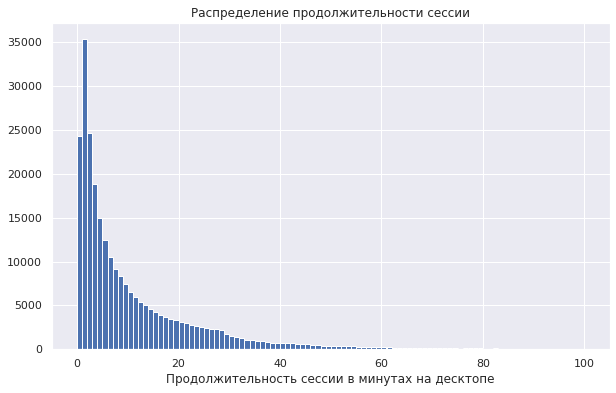

In [255]:
plt.figure(figsize = (10,6))
visits_desktop['duration'].hist(bins=100, range = (0,100))
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительность сессии в минутах на десктопе')

In [256]:
visits_touch['duration'].mode()

0    1.0
dtype: float64

Text(0.5, 0, 'Продолжительность сессии в минутах на мобильной версии')

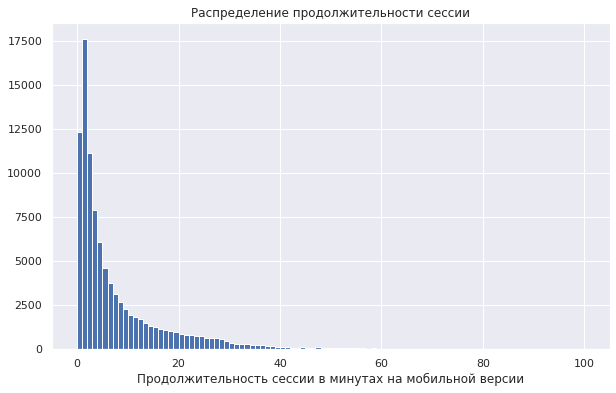

In [257]:
plt.figure(figsize = (10,6))
visits_touch['duration'].hist(bins=100, range = (0,100))
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительность сессии в минутах на мобильной версии')

И для десктопной версии, и для мобильной версии наиболее частое значение длительности сессии 1 минута.

In [258]:
visits_desktop['duration'].describe()

count    262567.000000
mean         11.721481
std          17.784328
min         -46.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: duration, dtype: float64

In [259]:
visits_desktop = visits_desktop.query('duration > 0')

In [260]:
visits_desktop['duration'].mean().round(2)

12.88

In [261]:
visits_desktop['duration'].describe()

count    238876.000000
mean         12.884309
std          18.238725
min           0.316667
25%           2.000000
50%           7.000000
75%          17.000000
max         711.000000
Name: duration, dtype: float64

In [262]:
visits_touch['duration'].mean().round(2)

7.99

In [263]:
visits_touch['duration'].describe()

count    96833.000000
mean         7.993657
std         12.542192
min          0.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        514.000000
Name: duration, dtype: float64

In [264]:
visits_touch.query('duration == 0')

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_day,first_visit_month,duration
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,2017-07-01,0.0
60,touch,2017-11-19 14:57:00,5,2017-11-19 14:57:00,4739090219603452344,2017-01-01,2017-11-01,2017-11-16,2017-11-19,2017-11-01,0.0
81,touch,2017-09-04 17:15:00,3,2017-09-04 17:15:00,11406453429526853581,2017-01-01,2017-09-01,2017-08-31,2017-09-04,2017-09-01,0.0
106,touch,2018-05-15 22:38:00,2,2018-05-15 22:38:00,3759848861531884050,2018-01-01,2018-05-01,2018-05-10,2018-05-15,2017-12-01,0.0
150,touch,2018-04-28 09:31:00,4,2018-04-28 09:31:00,12847990926658151448,2018-01-01,2018-04-01,2018-04-26,2018-04-28,2018-03-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...
358415,touch,2018-03-30 09:24:00,2,2018-03-30 09:24:00,10203284965226984791,2018-01-01,2018-03-01,2018-03-29,2018-03-30,2018-03-01,0.0
358442,touch,2017-12-04 13:05:00,4,2017-12-04 13:05:00,17781773683030280841,2017-01-01,2017-12-01,2017-11-30,2017-12-04,2017-12-01,0.0
358451,touch,2017-10-28 17:01:00,5,2017-10-28 17:01:00,9712237456213480472,2017-01-01,2017-10-01,2017-10-26,2017-10-28,2017-10-01,0.0
358507,touch,2017-12-07 14:42:00,9,2017-12-07 14:42:00,8638199837440131075,2017-01-01,2017-12-01,2017-12-07,2017-12-07,2017-10-01,0.0


При этом средняя длительность сессии на десктопе почти на 4 минуты больше сессии на мобильной версии сайта. Интересно отметить, что для мобильной версии существует нулевое значение сессии.Таких сессий более 12000. Необходимо подробнее проанализировать именно эту часть визитов для выявления возможных проблем.  
Определим, как часто пользователи возвращаются на сайт Яндекс.Афиши, применив когортный анализ. Будем разделять пользователей по месяцу первого визита.

In [265]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_day,first_visit_month,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,2017-12-01,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,2018-02-01,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,2018-03-01,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,2017-12-01,0.0


In [266]:
visits['cohort_lifetime'] = ((
    visits['visit_month'] - visits['first_visit_month'])/np.timedelta64(1, 'M')).astype('float').round()
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [267]:
cohorts.head(20)

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0.0,13259
1,2017-06-01,1.0,1043
2,2017-06-01,2.0,713
3,2017-06-01,3.0,814
4,2017-06-01,4.0,909
5,2017-06-01,5.0,947
6,2017-06-01,6.0,809
7,2017-06-01,7.0,766
8,2017-06-01,8.0,694
9,2017-06-01,9.0,674


Из полученной таблицы видно, что как минимум у двух когорт (июнь 2017 и июль 2017) наблюдается падение числа пользователей уже на следующий месяц жизни когорты. 


Посмотрим, сколько пользователей было в каждой когорте.

In [268]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}).reset_index()
initial_users_count

,index,first_visit_month,cohort_users
0,0,2017-06-01,13259
1,12,2017-07-01,13140
2,23,2017-08-01,10181
3,33,2017-09-01,16704
4,42,2017-10-01,25977
5,50,2017-11-01,27248
6,57,2017-12-01,25268
7,63,2018-01-01,22624
8,68,2018-02-01,22197
9,72,2018-03-01,20589


Text(0.5, 1.0, 'Количество пользователей в когорте')

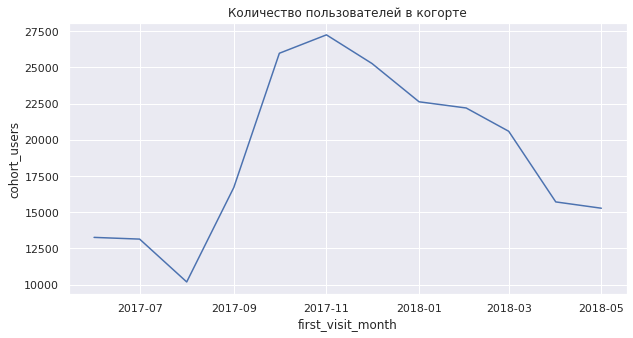

In [269]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.lineplot(x='first_visit_month', y='cohort_users', data=initial_users_count)
plt.title('Количество пользователей в когорте')

По нашей выборке рост числа пользователей по когортам наблюдался до ноября 2017. После этого началось постоянное снижение новых пользователей до мая 2018 года.

Расчитаем коэффициент удержания пользователей.

In [270]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(
    index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

print (retention_pivot)

cohort_lifetime    0.0       1.0       2.0       3.0       4.0       5.0   \
first_visit_month                                                           
2017-06-01          1.0  0.078664  0.053775  0.061392  0.068557  0.071423   
2017-07-01          1.0  0.056088  0.051294  0.056164  0.058219  0.048174   
2017-08-01          1.0  0.076908  0.062862  0.062764  0.050093  0.044004   
2017-09-01          1.0  0.085489  0.069205  0.050706  0.039392  0.037835   
2017-10-01          1.0  0.078608  0.052239  0.038958  0.034261  0.032221   
2017-11-01          1.0  0.078281  0.044113  0.038682  0.033727  0.023415   
2017-12-01          1.0  0.055802  0.037993  0.031107  0.020263  0.019036   
2018-01-01          1.0  0.059715  0.039339  0.024973  0.020244       NaN   
2018-02-01          1.0  0.057080  0.025454  0.020093       NaN       NaN   
2018-03-01          1.0  0.041818  0.027053       NaN       NaN       NaN   
2018-04-01          1.0  0.048380       NaN       NaN       NaN       NaN   

Отобразим полученную таблицу коэффициентов на графике.

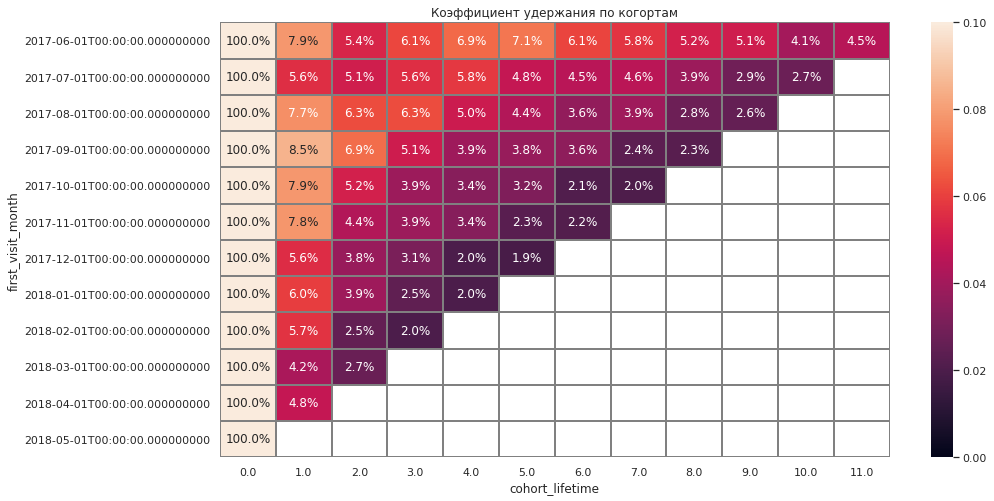

In [271]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Коэффициент удержания по когортам')
sns.heatmap(retention_pivot, vmin=0, vmax=0.1, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Коэффициент удержания для всхе когорт не превышает 10% ни на одном из промежутков жизни когорты. Самой "удерживающейся" когортой оказалась когорта июня 2017.Коэффициент удержания снизился с 7.9% др 4.5%. Коэффициент удержания остальных когорт снизился примерно до 2%. В ноябре 2017 был незначительный рост коэффициента, но после этого снова продолжилось падение.  
Таким образом, несмотря на рост пользователей Яндекс.Афиши с течением времени, пользователи не возвращаются за повторными покупками.

## Анализ продаж

Проанализируем таблицу с продажами и ответим на следущие вопросы:

1. Когда люди начинают покупать?
2. Сколько раз покупают за период?
3. Какой средний чек?
4. Сколько денег приносят? (LTV)

In [272]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [273]:
orders['order_day'] = orders['buy_ts'].astype('datetime64[D]')

Определим первый день покупки каждого пользователя.

In [274]:
first_order_day = orders.groupby(['uid'])['order_day'].min()
first_order_day.name = 'first_order_day' 
orders = orders.join(first_order_day,on='uid')

In [275]:
orders.head()

,buy_ts,revenue,uid,order_day,first_order_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


Также определим первый день визита пользователя.

In [276]:
first_visit_day = visits.groupby(['uid'])['visit_day'].min()
first_visit_day.name = 'first_visit_day' 
visits = visits.join(first_visit_day,on='uid')

first_visit_day

uid
11863502262781         2018-03-01
49537067089222         2018-02-06
297729379853735        2017-06-07
313578113262317        2017-09-18
325320750514679        2017-09-30
                          ...    
18446403737806311543   2017-11-30
18446424184725333426   2017-12-06
18446556406699109058   2018-01-01
18446621818809592527   2017-12-27
18446676030785672386   2017-10-04
Name: first_visit_day, Length: 228169, dtype: datetime64[ns]

In [277]:
visits_orders = pd.merge(orders, first_visit_day, how='left', on=['uid']) 

In [278]:
visits_orders

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2017-10-23


Расчитаем столбец think_time как разницу между датой первого визита и датой покупки.

In [279]:
visits_orders['think_time'] = visits_orders['first_order_day'] - visits_orders['first_visit_day']

In [280]:
visits_orders

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0 days
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0 days
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0 days
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0 days
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0 days
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31,0 days
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31,0 days
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31,0 days
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2017-10-23,220 days


In [281]:
visits_orders['think_time'].value_counts()

0 days      32334
1 days       2971
2 days       1154
4 days        757
3 days        707
            ...  
353 days        1
307 days        1
281 days        1
335 days        1
325 days        1
Name: think_time, Length: 349, dtype: int64

In [282]:
visits_orders['think_time'].describe()

count                      50415
mean     17 days 14:40:09.997024
std      46 days 11:15:36.419743
min              0 days 00:00:00
25%              0 days 00:00:00
50%              0 days 00:00:00
75%              4 days 00:00:00
max            363 days 00:00:00
Name: think_time, dtype: object

In [283]:
visits_orders['think_time'] = visits_orders['think_time'].dt.days

Text(0.5, 0, 'Время принятия решения о покупке в днях')

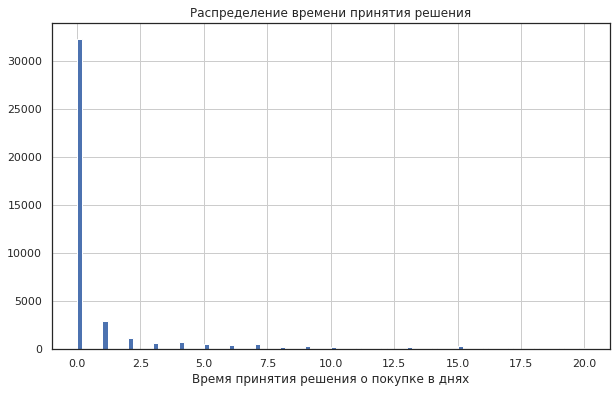

In [284]:
plt.figure(figsize = (10,6))
visits_orders['think_time'].hist(bins=100, range = (0,20))
plt.title('Распределение времени принятия решения')
plt.xlabel('Время принятия решения о покупке в днях')

75% пользователей совершили свою первую покупку максимум через 4 дня после первого визита. При этом половина пользователей совершили покупку в день визита.

In [285]:
visits_orders.query('think_time > 4').sort_values('think_time', ascending=False)

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time
49654,2018-05-30 11:34:00,0.61,15758490655816676033,2018-05-30,2018-05-30,2017-06-01,363
50275,2018-05-31 17:35:00,7.33,6916757527179896321,2018-05-31,2018-05-31,2017-06-02,363
49993,2018-05-31 10:59:00,5.32,17701657587540811463,2018-05-31,2018-05-31,2017-06-07,358
49569,2018-05-29 21:51:00,0.24,12282157960125853781,2018-05-29,2018-05-29,2017-06-06,357
49359,2018-05-28 19:15:00,0.92,6079087450327100134,2018-05-28,2018-05-28,2017-06-05,357
...,...,...,...,...,...,...,...
15769,2017-11-02 11:24:00,1.53,10175434072961877662,2017-11-02,2017-11-02,2017-10-28,5
15729,2017-11-01 22:48:00,2.44,11648183893720941512,2017-11-01,2017-11-01,2017-10-27,5
15619,2017-11-01 11:07:00,0.80,17497868304981070406,2017-11-01,2017-06-06,2017-06-01,5
44738,2018-04-19 22:04:00,3.42,16908736769990743071,2018-04-19,2018-04-19,2018-04-14,5


In [286]:
visits_orders.query('think_time > 180').sort_values('think_time', ascending=False)

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time
49654,2018-05-30 11:34:00,0.61,15758490655816676033,2018-05-30,2018-05-30,2017-06-01,363
50275,2018-05-31 17:35:00,7.33,6916757527179896321,2018-05-31,2018-05-31,2017-06-02,363
49993,2018-05-31 10:59:00,5.32,17701657587540811463,2018-05-31,2018-05-31,2017-06-07,358
49569,2018-05-29 21:51:00,0.24,12282157960125853781,2018-05-29,2018-05-29,2017-06-06,357
49359,2018-05-28 19:15:00,0.92,6079087450327100134,2018-05-28,2018-05-28,2017-06-05,357
...,...,...,...,...,...,...,...
37681,2018-03-02 08:55:00,3.05,12673339288055287488,2018-03-02,2018-03-02,2017-09-02,181
49448,2018-05-29 11:03:00,0.85,11725590276958678720,2018-05-29,2018-05-29,2017-11-29,181
46061,2018-04-30 22:18:00,8.55,16191814984681587403,2018-04-30,2018-04-30,2017-10-31,181
39028,2018-03-08 15:28:00,3.67,14481163132396345939,2018-03-08,2018-03-08,2017-09-08,181


Более 1000 пользователей вернулись на сайт за первой покупкой спустя полгода. Можно сказать, что перспектива для более качественного удержания пользователей есть. Необходимо посмотреть, есть ли связь между некоторыми маркетинговыми акциями и покупками самых "задержавшихся" пользователей.

Определим, сколько покупок совершают пользователи в месяц, в неделю и в день.

In [287]:
orders['order_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [288]:
orders_month = orders.groupby('order_month').agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
orders_month['uid'].mean().round()

3155.0

In [289]:
orders_month['revenue'].mean().round()

19389.0

In [290]:
orders_month['revenue_per_user'] = orders_month['revenue']/orders_month['uid']
orders_month

,order_month,uid,revenue,revenue_per_user
0,2017-06-01,2023,9557.49,4.724414
1,2017-07-01,1984,12539.47,6.320297
2,2017-08-01,1472,8758.78,5.950258
3,2017-09-01,2750,18345.51,6.671095
4,2017-10-01,4675,27987.70,5.986674
5,2017-11-01,4547,27069.93,5.953360
6,2017-12-01,4942,36388.60,7.363132
7,2018-01-01,3898,19417.13,4.981306
8,2018-02-01,4258,25560.54,6.002945
9,2018-03-01,4181,28834.59,6.896577


Text(0.5, 1.0, 'Доход с одного пользователя в месяц')

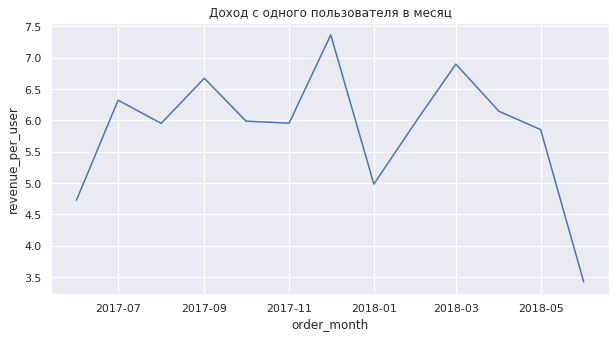

In [291]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.lineplot(x='order_month', y='revenue_per_user', data=orders_month)
plt.title('Доход с одного пользователя в месяц')

В среднем в месяц совершают 3155 покупок, средний чек в месяц - 19389 рублей. 
При этом пиковый доход на одного пользователя наблюдаем в декабре 2017. Затем подъем в марте 2018, а далее график стремится вниз.

In [292]:
orders_week = orders.groupby('order_week').agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
orders_week['uid'].mean().round()

818.0

In [293]:
orders_week['revenue'].mean().round()

4756.0

In [294]:
orders_week

,order_week,uid,revenue
0,2017-06-01,774,2546.66
1,2017-06-08,478,2536.51
2,2017-06-15,310,1527.33
3,2017-06-22,396,2099.22
4,2017-06-29,416,2449.82
5,2017-07-06,445,2675.45
6,2017-07-13,733,4922.39
7,2017-07-20,396,2240.05
8,2017-07-27,285,1527.42
9,2017-08-03,264,1442.06


Text(0.5, 1.0, 'Доход с одного пользователя в неделю')

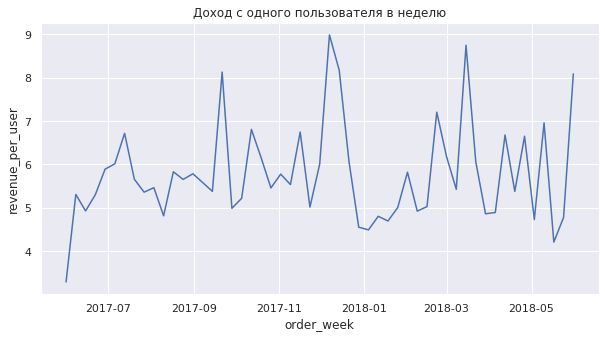

In [295]:
orders_week['revenue_per_user'] = orders_week['revenue']/orders_week['uid']
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.lineplot(x='order_week', y='revenue_per_user', data=orders_week)
plt.title('Доход с одного пользователя в неделю')

В среднем в неделю совершают 818 покупок, средний чек - 4756 рублей.  
График дохода на одного пользователя по неделям имеет скачкообразный характер с повторяющимися резкими выпадами. 

In [296]:
orders_day = orders.groupby('order_day').agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
orders_day['uid'].mean().round()

128.0

In [297]:
orders_day['revenue'].mean().round()

692.0

Text(0.5, 1.0, 'Доход с одного пользователя в день')

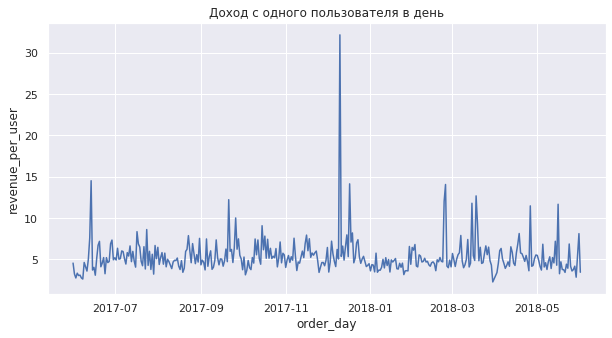

In [298]:
orders_day['revenue_per_user'] = orders_day['revenue']/orders_day['uid']
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.lineplot(x='order_day', y='revenue_per_user', data=orders_day)
plt.title('Доход с одного пользователя в день')

Text(0.5, 0, 'Доход на одного пользователя')

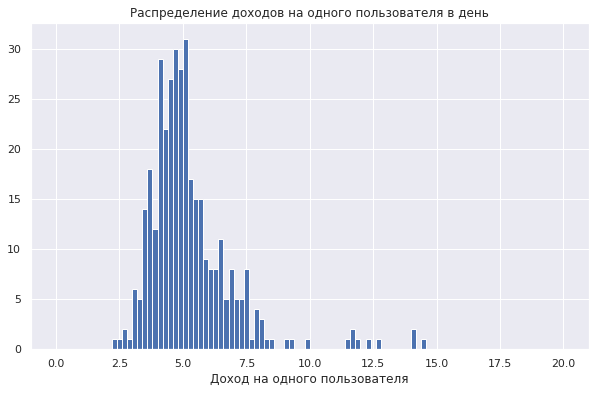

In [299]:
plt.figure(figsize = (10,6))
orders_day['revenue_per_user'].hist(bins=100, range = (0,20))
plt.title('Распределение доходов на одного пользователя в день')
plt.xlabel('Доход на одного пользователя')

В среднем в день совершают 128 покупок, средний чек - 692 рубля.  
График дохода на одного пользователя по дням очень схож с белым шумом. Само распределение имеет колокобразную форму. Это может означать, что мы не можем качественно предсказать ежедневный доход на одного пользователя на будущие периоды.

Определим итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок.

Начнем с разделения на когорты в зависимости от первого месяца покупки.

In [300]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [301]:
first_orders

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01
...,...,...
36518,18445147675727495770,2017-11-01
36519,18445407535914413204,2017-09-01
36520,18445601152732270159,2018-03-01
36521,18446156210226471712,2018-02-01


Вычислим число новых покупателей за каждый месяц.

In [302]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [303]:
orders_first_month = pd.merge(orders,first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [304]:
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Text(0.5, 1.0, 'Количество покупателей в когорте')

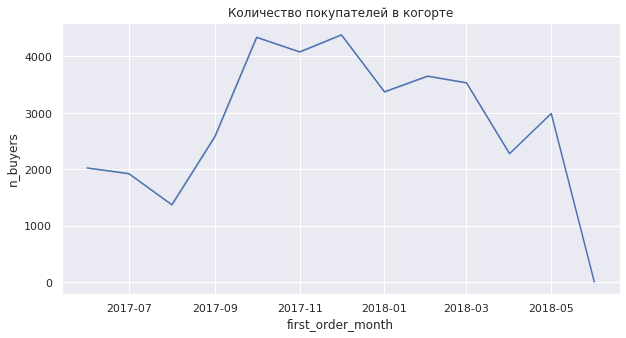

In [305]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.lineplot(x='first_order_month', y='n_buyers', data=report)
plt.title('Количество покупателей в когорте')

Число покупателей в когорте растет до декабря 2017 года. Затем наблюдается спад новых покупателей.

In [306]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [307]:
report['ltv'] = (report['revenue'] / report['n_buyers']).round(2)

In [308]:
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')
result.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


In [309]:
result['total'] = result.sum(axis=1)
result

age,0,1,2,3,4,5,6,7,8,9,10,11,total
first_order_month,,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26,11.88
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN,8.40
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN,8.47
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN,13.43
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN,6.36
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN,6.38
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN,7.65
2018-01-01,4.14,0.29,0.30,0.14,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.93
2018-02-01,4.16,0.28,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.59


Самой ценной для нас оказалась когорта 2017-09-01. В среднем каждый покупатель из этой когорты принес по 13,43 рубля выручки за 9 месяцев «жизни».

Посчитаем CAC каждой когорты.

In [310]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [311]:
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby('month')['costs'].sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [312]:
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [313]:
report

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.72
1,2017-06-01,2023,2017-07-01,981.82,1,0.49
2,2017-06-01,2023,2017-08-01,885.34,2,0.44
3,2017-06-01,2023,2017-09-01,1931.30,3,0.95
4,2017-06-01,2023,2017-10-01,2068.58,4,1.02
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2,0.32
75,2018-04-01,2276,2018-04-01,10600.69,0,4.66
76,2018-04-01,2276,2018-05-01,1209.92,1,0.53
77,2018-05-01,2988,2018-05-01,13925.76,0,4.66


In [314]:
report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='cac', 
    aggfunc='mean')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091
2017-07-01,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,NaN
2017-08-01,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,NaN,NaN
2017-09-01,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,NaN,NaN,NaN
2017-10-01,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,NaN,NaN,NaN,NaN
2017-11-01,9.288870,9.288870,9.288870,9.288870,9.288870,9.288870,9.288870,NaN,NaN,NaN,NaN,NaN
2017-12-01,8.741809,8.741809,8.741809,8.741809,8.741809,8.741809,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,9.937302,9.937302,9.937302,9.937302,9.937302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,8.962758,8.962758,8.962758,8.962758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Рассчитаем ROMI: поделим LTV на CAC. 

In [315]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

output.cumsum(axis=1).round(2).fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.89,
2017-08-01,0.49,0.53,0.58,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.88,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.5,0.5,0.51,,,,,,,,


Таким образом, получаем неутешительные результаты: окупились только две когорты: июнь 2017 и сентябрь 2017. Июньская когорта окупилась на 7ой месяц жизни, а сентябрьская на 4ый.

In [316]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.540788
1     0.582061
2     0.631207
3     0.719778
4     0.782841
5     0.859997
6     0.896532
7     0.969995
8     1.053654
9     0.964703
10    1.095217
11    1.334068
dtype: float64

В среднем когорты окупаются только на 9ый месяц жизни.  
Проанализируем окупаемость когорт в зависимости от устройств.

In [317]:
visits

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_day,first_visit_month,duration,cohort_lifetime,first_visit_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,2017-12-01,18.000000,0.0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,2018-02-01,28.000000,0.0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,2017-07-01,0.000000,0.0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,2018-03-01,24.000000,2.0,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,2017-12-01,0.000000,0.0,2017-12-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-01-01,2017-07-01,2017-07-27,2017-07-29,2017-07-01,0.316667,0.0,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-25,2018-01-01,0.316667,0.0,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-01-01,2018-03-01,2018-03-01,2018-03-03,2018-03-01,0.316667,0.0,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-01-01,2017-11-01,2017-11-02,2017-11-02,2017-11-01,0.316667,0.0,2017-11-02


In [318]:
visits_orders

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2017-10-23,220


In [319]:
visits_first = visits.query('visit_day == first_visit_day')

In [320]:
users_device = visits_first[['uid', 'device']]
users_device

,uid,device
0,16879256277535980062,touch
1,104060357244891740,desktop
2,7459035603376831527,touch
4,9969694820036681168,desktop
5,16007536194108375387,desktop
...,...,...
359395,18363291481961487539,desktop
359396,18370831553019119586,touch
359397,18387297585500748294,desktop
359398,18388616944624776485,desktop


In [321]:
visits_orders['order_month'] = visits_orders['buy_ts'].astype('datetime64[M]')
first_order_month = visits_orders.groupby(['uid'])['order_month'].min()
first_order_month.name = 'first_order_month' 
visits_orders = visits_orders.join(first_order_month,on='uid')

In [322]:
visits_orders_device = visits_orders.merge(users_device, on='uid')
visits_orders_device.head()

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time,order_month,first_order_month,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop


In [323]:
visits_orders_desktop = visits_orders_device.query('device == "desktop"')
visits_orders_touch = visits_orders_device.query('device == "touch"')

In [324]:
visits_orders_touch

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time,order_month,first_order_month,device
508,2017-06-01 10:58:00,3.73,11062788618907079633,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,touch
607,2017-06-01 17:20:00,2.08,13476545380596382515,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,touch
613,2017-06-01 17:33:00,11.00,16674220541096562302,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,touch
614,2017-06-01 17:33:00,11.00,16674220541096562302,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,touch
615,2017-06-27 23:24:00,3.05,16674220541096562302,2017-06-27,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,touch
...,...,...,...,...,...,...,...,...,...,...
60356,2018-05-31 21:54:00,3.67,8148444354982684070,2018-05-31,2018-05-31,2018-05-31,0,2018-05-01,2018-05-01,touch
60363,2018-05-31 22:16:00,7.33,9985845906947650101,2018-05-31,2018-05-31,2017-09-20,253,2018-05-01,2018-05-01,touch
60372,2018-05-31 23:01:00,0.24,8971807372263051413,2018-05-31,2018-05-31,2018-04-10,51,2018-05-01,2018-05-01,touch
60387,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-31,2018-05-31,2018-05-31,0,2018-05-01,2018-05-01,touch


In [325]:
def romi(df):
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    cohorts = df.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].astype('float').round()
    report['ltv'] = (report['revenue'] / report['n_buyers']).round(2)
    result = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    result= result.fillna('')
    report_new = pd.merge(report, monthly_costs, left_on=['first_order_month'], right_on=['month'])
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new.pivot_table(index='first_order_month', columns='age', values='cac', aggfunc='mean')
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

    return (output.cumsum(axis=1).round(2).fillna(' '))

In [326]:
romi(visits_orders_desktop)

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,0.62,0.69,0.75,0.89,1.04,1.15,1.3,1.38,1.47,1.55,1.65,1.68
2017-07-01,0.60,0.64,0.72,0.75,0.76,0.78,0.79,0.8,0.82,0.84,0.85,
2017-08-01,0.48,0.52,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.79,,
2017-09-01,0.57,0.67,0.71,1.13,1.19,1.26,1.33,1.36,1.38,,,
2017-10-01,0.61,0.69,0.72,0.74,0.76,0.78,0.79,0.8,,,,
2017-11-01,0.54,0.59,0.62,0.66,0.67,0.68,0.69,,,,,
2017-12-01,0.55,0.59,0.78,1.01,1.07,1.14,,,,,,
2018-01-01,0.39,0.42,0.47,0.49,0.5,,,,,,,
2018-02-01,0.43,0.49,0.5,0.51,,,,,,,,


In [327]:
romi(visits_orders_touch)

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,0.08,0.09,0.09,0.09,0.1,0.1,0.1,0.1,0.1,0.11,0.11,0.12
2017-07-01,0.15,0.16,0.16,0.17,0.18,0.18,0.18,0.19,0.19,0.19,0.2,
2017-08-01,0.11,0.11,0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.14,,
2017-09-01,0.13,0.17,0.19,0.2,0.21,0.21,0.24,0.25,0.25,,,
2017-10-01,0.12,0.13,0.13,0.13,0.13,0.13,0.13,0.14,,,,
2017-11-01,0.14,0.14,0.15,0.15,0.15,0.15,0.15,,,,,
2017-12-01,0.11,0.11,0.12,0.12,0.12,0.12,,,,,,
2018-01-01,0.09,0.1,0.1,0.1,0.1,,,,,,,
2018-02-01,0.12,0.12,0.12,0.13,,,,,,,,


Оценка метрик в разбивке в зависимости от устройства пользователя показала, что мобильная версия гораздо менее привлекательна десктопной. ROMI не превышает 0,25 для каждой когорты на каждом месяце жизни.  
В то же время по десктопу окупились 3 когорты из 12, а остальные когорты с течение времени все-таки стремятся к единичке. 

In [328]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [329]:
monthly_costs_source = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()

In [330]:
monthly_costs_source

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [331]:
users_source = visits_first[['uid', 'source_id']]
users_source

,uid,source_id
0,16879256277535980062,4
1,104060357244891740,2
2,7459035603376831527,5
4,9969694820036681168,3
5,16007536194108375387,5
...,...,...
359395,18363291481961487539,2
359396,18370831553019119586,1
359397,18387297585500748294,4
359398,18388616944624776485,5


In [332]:
visits_orders_source = visits_orders.merge(users_source, on='uid')
visits_orders_source.head()

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,think_time,order_month,first_order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3


In [333]:
def romi_source(df):
    cohort_sizes = df.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'source_id', 'n_buyers']
    cohorts = df.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].astype('float').round()
    report['ltv'] = (report['revenue'] / report['n_buyers']).round(2)
    result = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    result= result.fillna('')
    report_new = pd.merge(report, monthly_costs_source, left_on=['first_order_month', 'source_id'], right_on=['month', 'source_id'])
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new.pivot_table(index='first_order_month', columns='age', values='cac', aggfunc='mean')
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
    output_mean = output.cumsum(axis=1).mean(axis=0)
    return (output.cumsum(axis=1).round(2).fillna(' '), output_mean)

In [334]:
visits_orders_s1 = visits_orders_source.query('source_id == 1')
visits_orders_s2 = visits_orders_source.query('source_id == 2')
visits_orders_s3 = visits_orders_source.query('source_id == 3')
visits_orders_s4 = visits_orders_source.query('source_id == 4')
visits_orders_s5 = visits_orders_source.query('source_id == 5')
visits_orders_s9 = visits_orders_source.query('source_id == 9')
visits_orders_s10 = visits_orders_source.query('source_id == 10')

In [335]:
romi_source(visits_orders_s1)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         1.91   2.4  2.83  3.74  4.57  5.05  5.75  6.24  6.78   7.2   
 2017-07-01         1.84  2.02  2.83  3.07  3.22  3.35  3.42  3.53   3.7  3.88   
 2017-08-01         1.31   1.5  1.63  1.78  1.93  2.01  2.17  2.53  2.81  2.92   
 2017-09-01         1.38  1.89  1.99  2.14  2.17  2.24  2.59  2.74  2.89         
 2017-10-01         1.45  1.77  1.81  1.87   1.9  1.92  1.95     2               
 2017-11-01         1.83  1.97   2.1  2.23  2.26  2.28  2.29                     
 2017-12-01         1.13  1.24   1.3  1.37   1.4  1.42                           
 2018-01-01         0.97  1.01  1.03  1.14  1.16                                 
 2018-02-01         1.15  1.56  1.57  1.62                                       
 2018-03-01         1.79  2.21  2.49                                             
 2018-04-01     

In [336]:
romi_source(visits_orders_s2)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.99  1.08  1.13  1.39  1.57  1.69  1.93   2.1  2.28  2.38   
 2017-07-01         0.91  0.98  0.99  1.03  1.08   1.1  1.13  1.14  1.16  1.18   
 2017-08-01         0.49  0.55  0.56  0.58  0.62  0.63  0.64  0.68  0.68  0.68   
 2017-09-01         0.79  1.45  1.63  1.79  2.02  2.11  2.36  2.43  2.47         
 2017-10-01         0.90  1.19  1.27  1.38  1.43  1.48  1.49  1.52               
 2017-11-01         0.65  0.75  0.81   0.9  0.94  0.96  0.97                     
 2017-12-01         1.04   1.2  2.59  4.28  4.71  5.18                           
 2018-01-01         0.39  0.52  0.76  0.84  0.88                                 
 2018-02-01         0.42  0.49  0.53  0.56                                       
 2018-03-01         0.64  0.72  0.85                                             
 2018-04-01     

In [337]:
romi_source(visits_orders_s3)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.38  0.39  0.41  0.43  0.45  0.47  0.48  0.49  0.49  0.49   
 2017-07-01         0.42  0.44  0.45  0.48  0.48  0.48  0.49   0.5   0.5   0.5   
 2017-08-01         0.31  0.32  0.33  0.34  0.35  0.35  0.36  0.36  0.37  0.37   
 2017-09-01         0.47  0.49  0.52  0.52  0.54  0.55  0.56  0.57  0.58         
 2017-10-01         0.38  0.41  0.42  0.43  0.44  0.44  0.45  0.45               
 2017-11-01         0.35  0.37  0.37  0.38  0.38  0.39  0.39                     
 2017-12-01         0.37  0.38  0.39   0.4  0.41  0.42                           
 2018-01-01         0.29   0.3  0.31  0.31  0.32                                 
 2018-02-01         0.30  0.33  0.34  0.34                                       
 2018-03-01         0.34  0.35  0.37                                             
 2018-04-01     

In [339]:
romi_source(visits_orders_s4)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.62  0.63  0.65  0.71  0.85  1.03   1.2  1.22  1.25  1.35   
 2017-07-01         0.89  0.91  0.94  0.97  0.98     1  1.01  1.02  1.04  1.05   
 2017-08-01         0.60  0.62  0.63  0.66  0.68   0.7  0.71  0.73  0.74  0.75   
 2017-09-01         0.58  0.64  0.67  0.71  0.71  0.74  0.89  0.92  0.92         
 2017-10-01         0.87  0.91  0.94  0.96  0.98     1  1.02  1.03               
 2017-11-01         1.22  1.36  1.39  1.48  1.53  1.54  1.59                     
 2017-12-01         0.79  0.81  0.82  0.84  0.85  0.87                           
 2018-01-01         0.72  0.75  0.76  0.77  0.78                                 
 2018-02-01         0.83  0.86  0.86  0.87                                       
 2018-03-01         0.87  0.89   0.9                                             
 2018-04-01     

In [340]:
romi_source(visits_orders_s5)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.93  1.12  1.23  1.42  1.72  1.82  2.06  2.21  2.38  2.57   
 2017-07-01         0.94  0.98  1.05  1.07  1.08   1.1  1.11  1.13  1.14  1.15   
 2017-08-01         0.98  1.12  1.28  1.41  1.61  1.72   1.8  1.84  1.89  1.93   
 2017-09-01         1.15  1.18  1.23  3.71  3.83  4.14  4.19  4.22  4.22         
 2017-10-01         1.02  1.06  1.08  1.11  1.13  1.14  1.17  1.19               
 2017-11-01         0.64  0.67  0.69  0.69  0.71  0.72  0.73                     
 2017-12-01         0.83  0.86  0.87  0.88  0.89  0.89                           
 2018-01-01         0.63  0.69  0.74  0.74  0.75                                 
 2018-02-01         0.76  0.77  0.78  0.78                                       
 2018-03-01         0.85  0.86  0.86                                             
 2018-04-01     

In [341]:
romi_source(visits_orders_s9)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.86  0.88  1.02  1.16  1.23  1.33  1.46  1.49  1.62  1.65   
 2017-07-01         0.92  0.95  1.06  1.14   1.2  1.21  1.26  1.27  1.35   1.4   
 2017-08-01         1.03  1.08  1.26  1.32  1.34  1.35  1.39  1.49  1.51  1.54   
 2017-09-01         0.93  1.14  1.27  1.44  1.57   1.6  1.72  1.87  2.06         
 2017-10-01         1.10  1.22  1.31  1.34   1.4  1.51  1.51  1.52               
 2017-11-01         0.84  0.87  0.91  0.97     1  1.01  1.01                     
 2017-12-01         0.72  0.77  0.81  0.86  0.86  0.89                           
 2018-01-01         0.41  0.45  0.48  0.48  0.48                                 
 2018-02-01         0.77  0.81  0.82                                             
 2018-03-01         0.92  0.95  0.98                                             
 2018-04-01     

In [342]:
romi_source(visits_orders_s10)

(age                0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
 first_order_month                                                               
 2017-06-01         0.80  0.83                                      0.83         
 2017-07-01         0.65  0.97   1.3  1.38              1.38        1.38         
 2017-08-01         1.42  1.44  1.59                          1.61        1.62   
 2017-09-01         0.45  0.46  0.47  0.51  0.52              0.52  0.52         
 2017-10-01         0.95  0.98  0.98  0.99  1.02  1.04  1.05  1.07               
 2017-11-01         0.91  0.91  0.92  0.95  0.97  0.98  0.98                     
 2017-12-01         0.55  0.57                    0.58                           
 2018-01-01         0.49   0.5  0.51                                             
 2018-02-01         0.70  0.73  0.73                                             
 2018-03-01         1.38  1.41  1.42                                             
 2018-04-01     

Оценка ROMI в зависимости от источников позволила выявить, что наилучшим оказался источник 1: пользователи, пришедшие с этого источника, окупаются в среднем в первый месяц. Наихудшим оказался источник 3: ни одна когорта не окупилась.

Мы проанализировали наши продажи. В среднем в день совершают 128 покупок, средний чек - 692 рубля. Пользователя достаточно быстро принимают решения о покупке. Обычно первая покупка совершается в первый день визита. Но есть разница между поведением пользователей на десктопе и на мобильной версии. Необходимо более подробно ознакомиться с визитами пользователей на мобильном сайте и выявить проблему, с которыми они сталкиваются.


## Анализ маркетинговых затрат

Проанализируем маркетинговые затраты и ответим на вопросы:  
Сколько денег потратили? Всего / на каждый источник / по времени

In [177]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [178]:
costs['costs'].sum().round()

329132.0

In [179]:
orders['revenue'].sum().round()

252057.0

За рассматриваемый период наши затраты превысили доходы на 77000 рублей. 

In [198]:
costs_month = costs.groupby(['month'])['costs'].sum().reset_index()
costs_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [200]:
costs_month['costs'].mean().round()

27428.0

Самые большие затраты пришлись декабрь 2017го. Возможно, именно это повлияло на поведение декабрьской когорты. ROMI этой когорты выше по сравнению с предыдущими.

В среднем затраты составляют 27428 рублей в месяц.

In [221]:
costs_source = costs.groupby('source_id')['costs'].sum()
costs_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Text(0.5, 1.0, 'Распределение затрат по источникам')

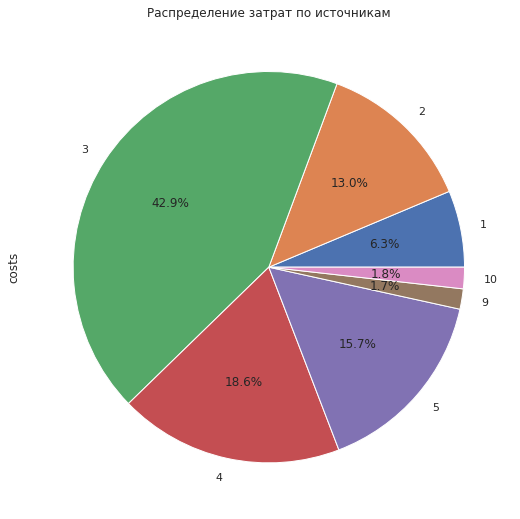

In [222]:
plot = costs_source.plot.pie(x='source_id', y='costs', figsize=(9, 9), autopct='%1.1f%%', legend=False)
plt.title('Распределение затрат по источникам')

С точки зрения источников самым дорогим оказался источник 3. Источники 9 и 10 занимают почти равные низкие позиции.

# Результаты исследования

Мы изучили данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года. Пользователи пользуются сервисом в основном на десктопе, чаще всего совершая первую покупку в первый же день визита.

Самой ценной для нас оказалась когорта 2017-09-01. В среднем каждый покупатель из этой когорты принес по 13,43 рубля выручки за 9 месяцев «жизни». В среднем когорты окупаются только на 9ый месяц жизни.  

Очевидно, что удачнее сервис работает на десктопе. Об этом говорит коэффициент ROMI. С точке зрения маркетинговых затрат необходимо сосредоточиться именно на десктопных пользователях. 

С мобильной версией оказалось все сложнее. Очень много сессий с длительностью 0 минут. Необходимо посмотреть на поведение пользователей в таких сессиях: почему так быстро покидают сайт.

Среди источников с положительной точки зрения можно выявить источник 1 и поработать с ним подробнее. А вот от источника 3 следует отказаться. Несмотря на большие вложения в него, ни одна когорта пользователей не окупилась.